# pytorch로 MNIST 분류기 만들기 
- 참고 자료: [pytorch tutorial - CIFAR10 image classification](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

### 1. 파라미터 정의 및 데이터 다운로드

In [4]:
epochs = 3
batch_size = 4
save_path = './mnist_cnn.pth'

# 데이터 다운로드
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
            )
train_dataset = torchvision.datasets.MNIST(root='data/',
                                            train=True,
                                            transform=transforms.ToTensor(),
                                            download=True
                                            )
train_dataloader = DataLoader(dataset=train_dataset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=2
                            )

test_dataset = torchvision.datasets.MNIST(root='data/',
                                            train=False,
                                            transform=transforms.ToTensor(),
                                            download=True
                                            )
test_dataloader = DataLoader(dataset=test_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=2
                            )

print('train 데이터 개수:', len(train_dataset))
print('클래스 종류:', train_dataset.classes)
print('train 데이터 정보:', train_dataset)

print('test 데이터 개수:', len(test_dataset))
print('클래스 종류:', test_dataset.classes)
print('test 데이터 정보:', test_dataset)

train 데이터 개수: 60000
클래스 종류: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
train 데이터 정보: Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: data/
    Transforms (if any): ToTensor()
    Target Transforms (if any): None
test 데이터 개수: 10000
클래스 종류: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
test 데이터 정보: Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: data/
    Transforms (if any): ToTensor()
    Target Transforms (if any): None


### 2. 모델, loss, optimizer 정의

In [1]:
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(320, 160)
        self.fc2 = nn.Linear(160, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

NameError: name 'nn' is not defined

In [5]:
# 모델 정의
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 3. 학습 후 가중치 저장

In [6]:
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')
torch.save(net.state_dict(), save_path)

[1,  2000] loss: 1.776
[1,  4000] loss: 0.321
[1,  6000] loss: 0.179
[1,  8000] loss: 0.155
[1, 10000] loss: 0.119
[1, 12000] loss: 0.114
[1, 14000] loss: 0.098
[2,  2000] loss: 0.083
[2,  4000] loss: 0.074
[2,  6000] loss: 0.073
[2,  8000] loss: 0.070
[2, 10000] loss: 0.064
[2, 12000] loss: 0.063
[2, 14000] loss: 0.070
[3,  2000] loss: 0.047
[3,  4000] loss: 0.051
[3,  6000] loss: 0.051
[3,  8000] loss: 0.056
[3, 10000] loss: 0.047
[3, 12000] loss: 0.044
[3, 14000] loss: 0.043
Finished Training


### 4. 테스트

In [11]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

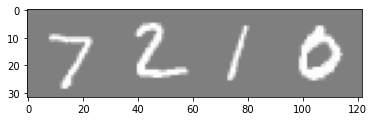

Ground Truth:  7 2 1 0
Predicted:  7 2 1 0


In [12]:
# batch=1 데이터 출력하기
test_iter = iter(test_dataloader)
images, labels = test_iter.next()
classes = [i for i in range(10)]

imshow(torchvision.utils.make_grid(images))
print('Ground Truth: ', ' '.join(f'{classes[labels[j]]}' for j in range(4)))


# 저장한 가중치 로드해 batch=1 데이터 예측하기
net = Net()
net.load_state_dict(torch.load(save_path))

outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]}' for j in range(4)))

### test data 전체 성능 확인

In [14]:
correct = 0
total = 0

# training이 아니기 때문에 gradient를 계산할 필요가 없음
# 메모리 사용량을 아끼기 위해 torch.no_grad()로 gradient 연산 옵션을 끈다.
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images)  # 모델 예측값
        _, predicted = torch.max(outputs.data, 1)  # 예측값 중 가장 값이 큰 클래스 하나 뽑기
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 98 %


### test data 클래스별 성능 확인

In [13]:
# 클래스별로 맞춘 개수 세기
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# test 단계이므로 gradient 연산을 하지 않음
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)

        # 클래스별로 모델 예측이 맞은 경우 세기
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 클래스별 성능 출력
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname} is {accuracy:.1f} %')

Accuracy for class: 0 is 99.5 %
Accuracy for class: 1 is 99.3 %
Accuracy for class: 2 is 99.0 %
Accuracy for class: 3 is 98.8 %
Accuracy for class: 4 is 99.3 %
Accuracy for class: 5 is 98.9 %
Accuracy for class: 6 is 98.6 %
Accuracy for class: 7 is 98.0 %
Accuracy for class: 8 is 97.0 %
Accuracy for class: 9 is 98.2 %
